# 📈 Análise Exploratória (EDA)
## 🔄 Ajuste do Diretório de Trabalho

Antes de carregar ou manipular arquivos, é importante garantir que estamos no diretório correto do projeto.  
O código abaixo verifica se o notebook está sendo executado a partir da pasta `notebooks`. Se for o caso, ele sobe um nível na hierarquia de diretórios para garantir que o diretório de trabalho seja a raiz do projeto.

Isso é útil para manter caminhos relativos consistentes ao acessar dados, scripts ou outros recursos do projeto.

📌 **Resumo do que o código faz:**
- Verifica se o diretório atual termina com `notebooks`.
- Se sim, volta uma pasta (para a raiz do projeto).
- Exibe o novo diretório de trabalho.


In [22]:
import os

# Verifica se o diretório de trabalho atual termina com 'notebooks'
if os.path.basename(os.getcwd()) == 'notebooks':
    # Se sim, sobe um nível de diretório para a pasta raiz do projeto
    os.chdir('..')

# Imprime o diretório de trabalho para confirmar que a mudança foi feita
print(f"Diretório de Trabalho Atual: {os.getcwd()}")

Diretório de Trabalho Atual: c:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov


## ⚙️ Carregamento de Bibliotecas e Configurações do Projeto

Nesta etapa, realizamos a importação das principais bibliotecas que serão utilizadas ao longo do projeto, organizadas por finalidade:

- 📁 **Configurações do Projeto**:  
  Importamos o módulo `src.config`, que armazena configurações como caminhos de arquivos, variáveis globais e parâmetros fixos.

- 📊 **Manipulação de Dados**:  
  - `pandas` e `numpy` para operações de estruturação e análise de dados.  
  - `duckdb` para consultas SQL diretamente em DataFrames.

- ⚙️ **Engenharia de Atributos**:  
  - `pandas_ta` é uma biblioteca especializada para análise técnica, útil para projetos com dados temporais (ex: séries financeiras).

- 📈 **Visualização de Dados**:  
  - `matplotlib.pyplot` e `seaborn` para construção de gráficos interativos e estilizados.

- 🧰 **Helpers do Notebook**:  
  - `display` do `IPython` facilita a visualização de objetos em células do notebook.

Além disso, aplicamos configurações visuais para padronizar os gráficos:
- Tema `whitegrid` do Seaborn.
- Estilo `fivethirtyeight` do Matplotlib.
- Habilitação do modo inline para que os gráficos sejam renderizados dentro do notebook.

```python
print("✅ Bibliotecas carregadas com sucesso!")


In [24]:
# --- Configurações do Projeto ---
# Importa nossas configurações (ex: caminho do DB)
import src.config as config

# --- Manipulação de Dados ---
import pandas as pd
import numpy as np
import duckdb

# --- Engenharia de Atributos ---
import pandas_ta as ta

# --- Visualização ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Helpers do Notebook ---
from IPython.display import display
import subprocess


# Garante que os gráficos sejam exibidos no notebook
%matplotlib inline 

print("✅ Bibliotecas carregadas com sucesso!")

✅ Bibliotecas carregadas com sucesso!


## 🧰 Configuração de Estilo e Exibição de Dados

Antes de iniciar a análise, definimos algumas configurações visuais e de exibição para melhorar a legibilidade dos outputs e a consistência gráfica.

### 📊 Configurações do `pandas`
- `max_columns = 100`: Permite visualizar até 100 colunas sem truncamento.
- `max_rows = 100`: Permite visualizar até 100 linhas diretamente no output.
- `float_format = '{:.2f}'`: Formata números decimais com 2 casas, facilitando a leitura.

```python
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
```

In [25]:
# Pandas display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Estilo visual com Seaborn (engloba Matplotlib)
sns.set_theme(
    context='notebook',
    style='whitegrid',
    palette='viridis',
    font='sans-serif',
    font_scale=1.1,
    rc={
        'figure.figsize': (12, 6),
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'lines.linewidth': 2,
        'grid.alpha': 0.3
    }
)

## 🗃️ Carregamento dos Dados - Fase 1

Nesta etapa, conectamos ao banco de dados local gerado na **Fase 1** do pipeline para carregar os dados da tabela `precos_diarios`.

É possível executar o pipeline para a extração de dados de duas maneiras:
- Utilizando o script de linha de comando: `python run_pipeline.py --start-date 2005-01-01`
- Ou executando diretamente o arquivo `run_pipeline.py` sem argumentos, utilizando os padrões definidos no projeto.

---

### ⚙️ Como o script `run_pipeline.py` funciona?

O script é responsável por iniciar a pipeline de dados, utilizando o módulo `argparse` para capturar dois argumentos opcionais de data:

- `--start-date`: data inicial da coleta. Se omitido, utiliza o valor de `config.START_DATE`.
- `--end-date`: data final da coleta. Se omitido, usa a data atual do sistema (`datetime.date.today()`).

Utilizamos o **DuckDB**, um banco de dados analítico embutido, eficiente para análise local de dados com sintaxe SQL.

📌 **Etapas realizadas:**
1. O caminho do banco de dados (`DB_PATH`) é recuperado do módulo de configurações `config`.
2. Estabelecemos uma conexão com o DuckDB em modo **somente leitura** (`read_only=True`), garantindo integridade.
3. Executamos uma query SQL para obter todos os registros da tabela `precos_diarios`.
4. A conexão é encerrada após a leitura.
5. O dataframe resultante é exibido com:
   - `df.info()` para verificar a estrutura.
   - `df.head()` para visualizar as primeiras linhas.

Em caso de falha, uma mensagem de erro orienta o usuário a verificar se o pipeline da Fase 1 foi executado corretamente e se o arquivo do banco existe no local esperado.


In [4]:
# --- Carregando os dados da Fase 1 ---

# O caminho para o banco de dados já está no nosso módulo 'config'
db_path = str(config.DB_PATH)

print(f"Carregando dados de: {db_path}")

try:
    # Conecta ao banco de dados DuckDB em modo de apenas leitura
    con = duckdb.connect(database=db_path, read_only=True)

    # Executa uma query SQL para selecionar todos os dados da nossa tabela
    df = con.execute("SELECT * FROM precos_diarios").fetchdf()

    # Fecha a conexão com o banco de dados
    con.close()

    # --- Verificação ---
    print("\n✅ Dados carregados com sucesso! Verificando a estrutura:")
    df.info()

    print("\nExibindo as 5 primeiras linhas:")
    display(df.head())

except Exception as e:
    print(f"❌ Ocorreu um erro ao carregar os dados: {e}")
    print("Verifique se o pipeline da Fase 1 foi executado com sucesso e se o arquivo do banco de dados existe no local correto.")

Carregando dados de: C:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov\data\mercados.duckdb

✅ Dados carregados com sucesso! Verificando a estrutura:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5359 entries, 0 to 5358
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   data                   5359 non-null   object 
 1   close_petroleo_brent   5359 non-null   float64
 2   close_petrobras        5359 non-null   float64
 3   close_dolar            5359 non-null   float64
 4   close_ibovespa         5359 non-null   float64
 5   close_sp500            5359 non-null   float64
 6   high_petroleo_brent    5359 non-null   float64
 7   high_petrobras         5359 non-null   float64
 8   high_dolar             5359 non-null   float64
 9   high_ibovespa          5359 non-null   float64
 10  high_sp500             5359 non-null   float64
 11  low_petroleo_brent     5359 non-null   float64
 12  low_

data  close_petroleo_brent  close_petrobras  close_dolar  \
0  2005-01-03                 42.12             2.74         2.15   
1  2005-01-04                 43.91             2.70         2.15   
2  2005-01-05                 43.39             2.69         2.15   
3  2005-01-06                 45.56             2.70         2.15   
4  2005-01-07                 45.43             2.71         2.15   

   close_ibovespa  close_sp500  high_petroleo_brent  high_petrobras  \
0        25722.00      1202.08                43.10            2.84   
1        24848.00      1188.05                44.13            2.78   
2        24692.00      1183.74                44.00            2.74   
3        24367.00      1187.89                45.75            2.72   
4        24747.00      1186.19                46.10            2.74   

   high_dolar  high_ibovespa  high_sp500  low_petroleo_brent  low_petrobras  \
0        2.17       26492.00     1217.80               41.25           2.74   
1        2.17       25873.00     1205.84               41.85           2.70   
2        2.17       25001.00     1192.73               42.60           2.67   
3        2.17       24808.00     1191.63               42.80           2.67   
4        2.17       24874.00     1192.20               44.75           2.69   

   low_dolar  low_ibovespa  low_sp500  open_petroleo_brent  open_petrobras  \
0       2.15      25671.00    1200.32                43.10            2.83   
1       2.15      24791.00    1185.39                42.18            2.76   
2       2.15      24523.00    1183.72                43.90            2.71   
3       2.15      24250.00    1183.27                43.39            2.71   
4       2.15      24376.00    1182.16                45.50            2.71   

   open_dolar  open_ibovespa  open_sp500  volume_petroleo_brent  \
0        2.17       26193.00     1211.92               69484.00   
1        2.17       25722.00     1202.08              100665.00   
2        2.17       24859.00     1188.05               91011.00   
3        2.17       24695.00     1183.74              122411.00   
4        2.17       24376.00     1187.89               99725.00   

   volume_petrobras  volume_dolar  volume_ibovespa  volume_sp500  \
0       30044800.00          0.00             0.00 1510800000.00   
1       37667200.00          0.00             0.00 1721000000.00   
2       30873600.00          0.00             0.00 1738900000.00   
3       28224000.00          0.00             0.00 1569100000.00   
4       25980800.00          0.00             0.00 1477900000.00   

   semana_do_mes  
0              1  
1              1  
2              1  
3              1  
4              1

## 🗓️ Ajuste do Índice Temporal

Para garantir uma manipulação adequada de séries temporais, realizamos o ajuste da coluna `data`, transformando-a no índice principal do DataFrame.

📌 **Etapas executadas:**
1. Convertida a coluna `'data'` para o tipo `datetime` com `pd.to_datetime()` para garantir que operações temporais funcionem corretamente (ex: resampling, filtros por período).
2. Definida como **índice do DataFrame** com `df.set_index('data', inplace=True)`, substituindo o índice numérico padrão.
3. Exibimos as primeiras linhas para confirmar a alteração, verificando que `'data'` agora aparece como índice à esquerda do DataFrame.

Esse passo é essencial em análises temporais, especialmente para séries de preços, permitindo ordenação cronológica, reamostragem e outras operações baseadas em tempo.


In [5]:
# Garante que a coluna 'data' esteja no formato datetime, caso ainda não esteja
df['data'] = pd.to_datetime(df['data'])

# Define a coluna 'data' como o novo índice do DataFrame
# O inplace=True modifica o DataFrame diretamente
df.set_index('data', inplace=True)

# Exibe as primeiras linhas para confirmar a mudança. 
# Note que 'data' agora está no lugar do índice numérico.
print("✅ Coluna 'data' definida como índice. A estrutura agora é:")
display(df.head())

✅ Coluna 'data' definida como índice. A estrutura agora é:


close_petroleo_brent  close_petrobras  close_dolar  \
data                                                             
2005-01-03                 42.12             2.74         2.15   
2005-01-04                 43.91             2.70         2.15   
2005-01-05                 43.39             2.69         2.15   
2005-01-06                 45.56             2.70         2.15   
2005-01-07                 45.43             2.71         2.15   

            close_ibovespa  close_sp500  high_petroleo_brent  high_petrobras  \
data                                                                           
2005-01-03        25722.00      1202.08                43.10            2.84   
2005-01-04        24848.00      1188.05                44.13            2.78   
2005-01-05        24692.00      1183.74                44.00            2.74   
2005-01-06        24367.00      1187.89                45.75            2.72   
2005-01-07        24747.00      1186.19                46.10            2.74   

            high_dolar  high_ibovespa  high_sp500  low_petroleo_brent  \
data                                                                    
2005-01-03        2.17       26492.00     1217.80               41.25   
2005-01-04        2.17       25873.00     1205.84               41.85   
2005-01-05        2.17       25001.00     1192.73               42.60   
2005-01-06        2.17       24808.00     1191.63               42.80   
2005-01-07        2.17       24874.00     1192.20               44.75   

            low_petrobras  low_dolar  low_ibovespa  low_sp500  \
data                                                            
2005-01-03           2.74       2.15      25671.00    1200.32   
2005-01-04           2.70       2.15      24791.00    1185.39   
2005-01-05           2.67       2.15      24523.00    1183.72   
2005-01-06           2.67       2.15      24250.00    1183.27   
2005-01-07           2.69       2.15      24376.00    1182.16   

            open_petroleo_brent  open_petrobras  open_dolar  open_ibovespa  \
data                                                                         
2005-01-03                43.10            2.83        2.17       26193.00   
2005-01-04                42.18            2.76        2.17       25722.00   
2005-01-05                43.90            2.71        2.17       24859.00   
2005-01-06                43.39            2.71        2.17       24695.00   
2005-01-07                45.50            2.71        2.17       24376.00   

            open_sp500  volume_petroleo_brent  volume_petrobras  volume_dolar  \
data                                                                            
2005-01-03     1211.92               69484.00       30044800.00          0.00   
2005-01-04     1202.08              100665.00       37667200.00          0.00   
2005-01-05     1188.05               91011.00       30873600.00          0.00   
2005-01-06     1183.74              122411.00       28224000.00          0.00   
2005-01-07     1187.89               99725.00       25980800.00          0.00   

            volume_ibovespa  volume_sp500  semana_do_mes  
data                                                      
2005-01-03             0.00 1510800000.00              1  
2005-01-04             0.00 1721000000.00              1  
2005-01-05             0.00 1738900000.00              1  
2005-01-06             0.00 1569100000.00              1  
2005-01-07             0.00 1477900000.00              1

## 📈 Visualização das Séries Temporais de Valor de Fechamento

Agora que o índice do DataFrame está configurado como uma série temporal (`data`), selecionamos apenas as colunas que representam Valor de fechamento (prefixo `close_`) para visualização.

📌 **Etapas realizadas:**
1. Utilizamos `df.filter(like='close')` para selecionar automaticamente todas as colunas com o prefixo `close_`, representando os preços de fechamento dos ativos.

2. Criamos múltiplos **subplots verticais**, um para cada ativo, com os seguintes parâmetros:
   - `nrows`: igual ao número de ativos.
   - `sharex=True`: todos os gráficos compartilham o mesmo eixo X (tempo), permitindo alinhamento temporal.

3. Cada subplot exibe a série temporal de um ativo individualmente:
   - O título de cada subplot é o nome da coluna (ativo).
   - O eixo Y representa o preço de fechamento.
   - A legenda é omitida (`legend=False`) para evitar poluição visual.

4. Um **título geral** é adicionado à figura, e o layout é ajustado com `tight_layout()` para evitar sobreposição de elementos.

Essa abordagem é útil para observar a evolução temporal individual dos ativos e comparar suas tendências visuais ao longo do tempo.


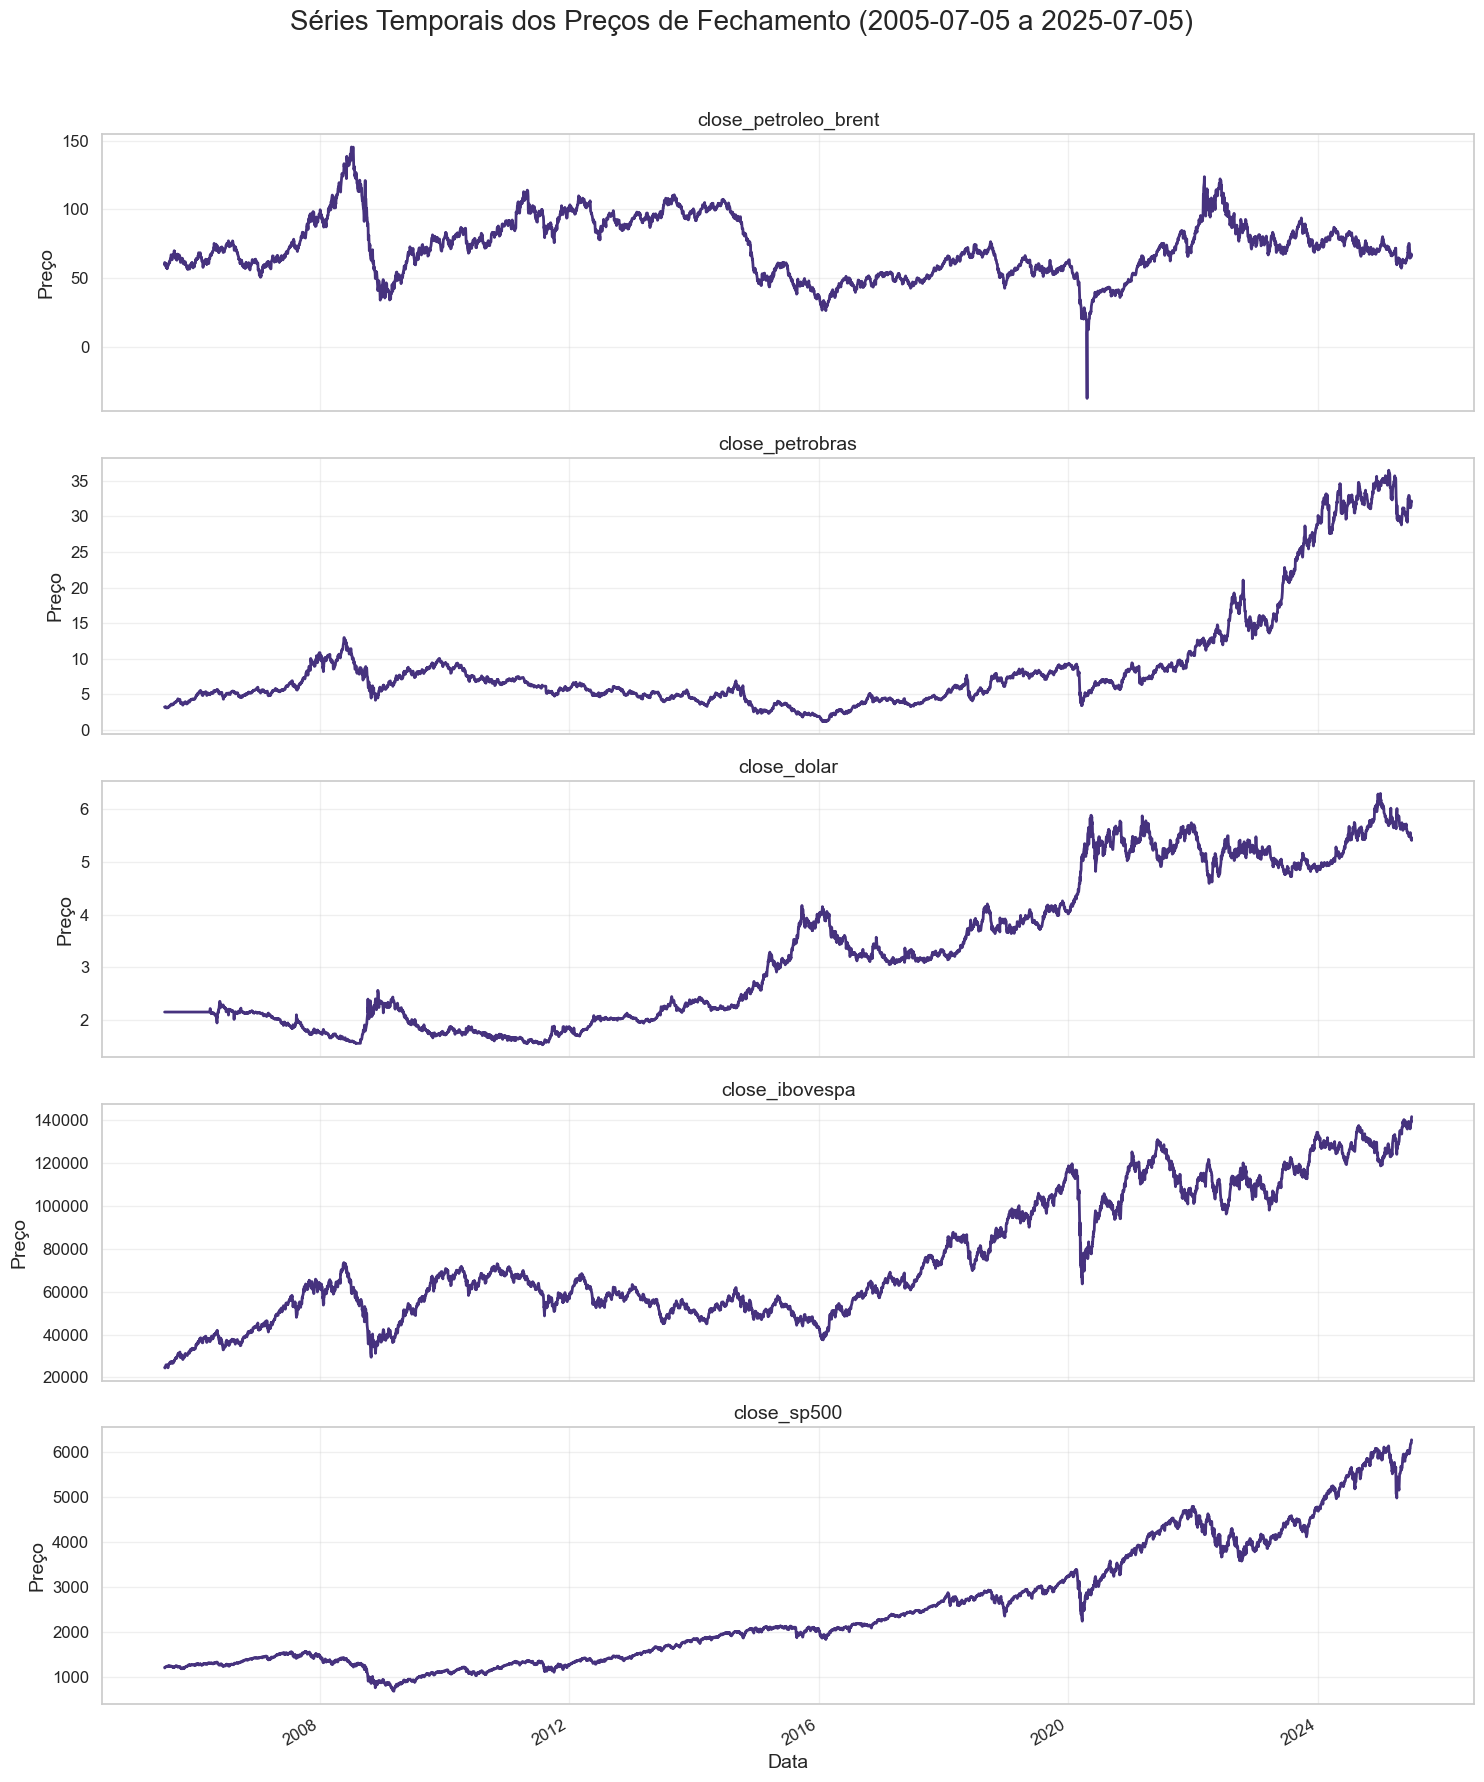

In [6]:
# O DataFrame 'df' já foi carregado e está com o índice de data configurado

# --- FILTRAGEM DE DADOS PARA O PERÍODO DE 2 ANOS ---

# 1. Define o período de análise desejado
start_date = '2005-07-05'
end_date = '2025-07-05'

# 2. Seleciona as colunas de fechamento
df_close = df.filter(like='close')

# 3. Filtra o DataFrame para conter apenas os dados do período de 2 anos
# Usamos .loc[] para fatiar o DataFrame com base no índice de data
df_close = df_close.loc[start_date:end_date]

# ---------------------------------------------------


# --- Criação dos Gráficos ---

# Cria uma figura com múltiplos subplots, um para cada ativo.
fig, axes = plt.subplots(
    nrows=len(df_close.columns), 
    ncols=1, 
    figsize=(15, 20), 
    sharex=True
)

# Define um título geral para a figura inteira
fig.suptitle(f'Séries Temporais dos Preços de Fechamento ({start_date} a {end_date})', fontsize=20, y=0.92)

# Itera sobre cada coluna de preço e cria um gráfico no seu respectivo eixo (subplot)
# Note que agora usamos o DataFrame filtrado: df_close_2y
for i, column in enumerate(df_close.columns):
    ax = axes[i]
    df_close[column].plot(ax=ax, legend=False)
    ax.set_title(column, fontsize=14)
    ax.set_ylabel('Preço')

# Ajusta o layout e o eixo x final
plt.xlabel('Data')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

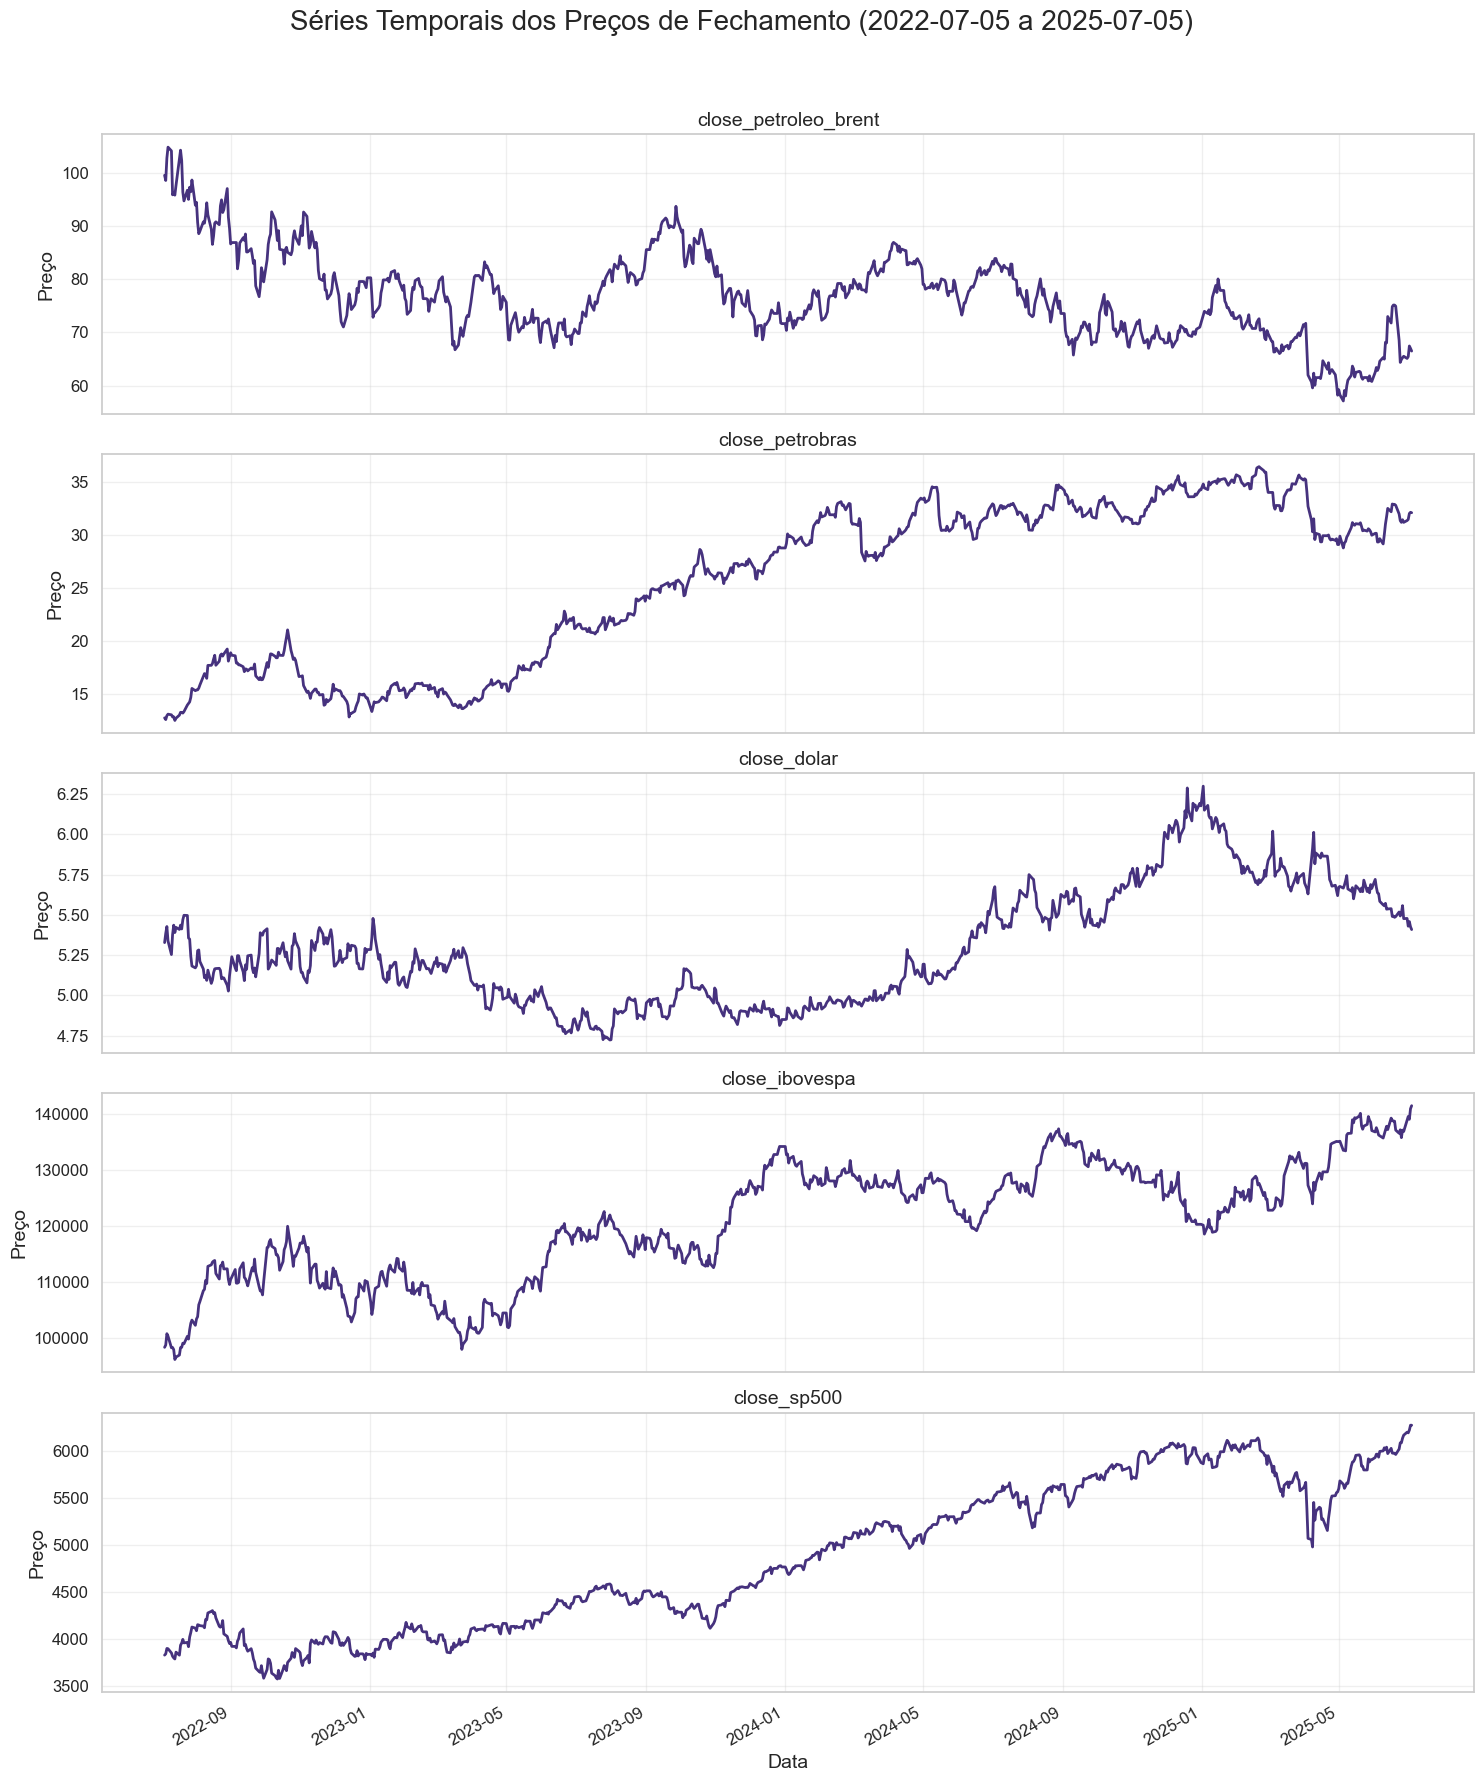

In [7]:
# O DataFrame 'df' já foi carregado e está com o índice de data configurado

# --- FILTRAGEM DE DADOS PARA O PERÍODO DE 2 ANOS ---

# 1. Define o período de análise desejado
start_date_2y = '2022-07-05'
end_date_2y = '2025-07-05'

# 2. Seleciona as colunas de fechamento
df_close = df.filter(like='close')

# 3. Filtra o DataFrame para conter apenas os dados do período de 2 anos
# Usamos .loc[] para fatiar o DataFrame com base no índice de data
df_close_2y = df_close.loc[start_date_2y:end_date_2y]

# ---------------------------------------------------


# --- Criação dos Gráficos ---

# Cria uma figura com múltiplos subplots, um para cada ativo.
fig, axes = plt.subplots(
    nrows=len(df_close_2y.columns), 
    ncols=1, 
    figsize=(15, 20), 
    sharex=True
)

# Define um título geral para a figura inteira
fig.suptitle(f'Séries Temporais dos Preços de Fechamento ({start_date_2y} a {end_date_2y})', fontsize=20, y=0.92)

# Itera sobre cada coluna de preço e cria um gráfico no seu respectivo eixo (subplot)
# Note que agora usamos o DataFrame filtrado: df_close_2y
for i, column in enumerate(df_close_2y.columns):
    ax = axes[i]
    df_close_2y[column].plot(ax=ax, legend=False)
    ax.set_title(column, fontsize=14)
    ax.set_ylabel('Preço')

# Ajusta o layout e o eixo x final
plt.xlabel('Data')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

## 📈 Cálculo e Distribuição dos Retornos Diários

Para analisar a variação percentual dos preços ao longo do tempo, calculamos os **retornos diários** dos ativos com base nas colunas de preços de fechamento.

### 🔢 Cálculo dos Retornos:
- Utilizamos `.pct_change()` para calcular a variação percentual diária de cada ativo.
- A primeira linha é removida com `.dropna()` pois não possui valor de referência para o cálculo do retorno.

```python
df_returns = df.filter(like='close').pct_change().dropna()


Retornos diários calculados. Exibindo as 5 primeiras linhas:


close_petroleo_brent  close_petrobras  close_dolar  \
data                                                             
2005-01-04                  0.04            -0.01         0.00   
2005-01-05                 -0.01            -0.00         0.00   
2005-01-06                  0.05             0.00         0.00   
2005-01-07                 -0.00             0.00         0.00   
2005-01-10                 -0.00            -0.01         0.00   

            close_ibovespa  close_sp500  
data                                     
2005-01-04           -0.03        -0.01  
2005-01-05           -0.01        -0.00  
2005-01-06           -0.01         0.00  
2005-01-07            0.02        -0.00  
2005-01-10           -0.02         0.00

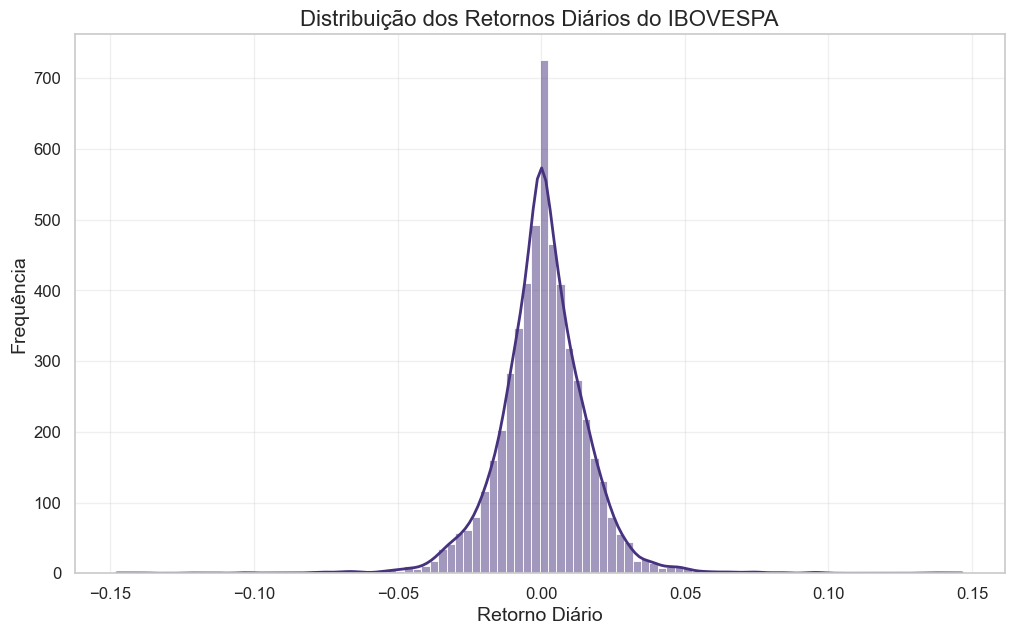

In [8]:
# --- Cálculo dos Retornos Diários ---

# Seleciona as colunas de fechamento e calcula a variação percentual diária
df_returns = df.filter(like='close').pct_change()

# O primeiro dia não tem retorno, então a primeira linha será NaN. Vamos removê-la.
df_returns = df_returns.dropna()

print("Retornos diários calculados. Exibindo as 5 primeiras linhas:")
display(df_returns.head())


# --- Visualização da Distribuição de Retornos do Ibovespa ---

# Usando o Seaborn para criar um histograma com uma curva de densidade (KDE)
plt.figure(figsize=(12, 7))
sns.histplot(df_returns['close_ibovespa'], kde=True, bins=100)

plt.title('Distribuição dos Retornos Diários do IBOVESPA')
plt.xlabel('Retorno Diário')
plt.ylabel('Frequência')
plt.show()

### Análise da Distribuição de Retornos do IBOVESPA

O histograma acima nos fornece um "raio-X" do comportamento diário do IBOVESPA, revelando as seguintes características-chave:

* **Centro da Distribuição:** Como esperado para retornos diários de mercado, a distribuição está fortemente centrada em **próximo de zero**. Isso indica que, na maioria dos dias, a variação do índice é mínima, seja ela positiva ou negativa.

* **Concentração e Volatilidade:** O pico alto e estreito da curva demonstra que a grande maioria dos retornos diários se concentra em um intervalo pequeno (aproximadamente de -2% a +2%). Isso significa que dias de baixa volatilidade são muito mais frequentes do que dias de grandes movimentações.

* **Caudas Pesadas (Leptocurtose):** Esta é a observação mais importante para a nossa modelagem. As "caudas" da distribuição, que se estendem para além de -10% e +10%, são visivelmente mais pronunciadas do que em uma distribuição normal (curva de sino).
    * **Implicação Prática:** **Eventos extremos**, tanto positivos quanto negativos, são **mais comuns** do que um modelo estatístico simples poderia prever. Nosso futuro modelo preditivo precisa ser robusto o suficiente para não ser excessivamente influenciado por esses "dias atípicos", que são uma característica inerente do mercado.

* **Simetria:** A distribuição aparenta ser razoavelmente simétrica, sugerindo que não há um viés significativo para retornos diários negativos ou positivos em termos de frequência histórica.

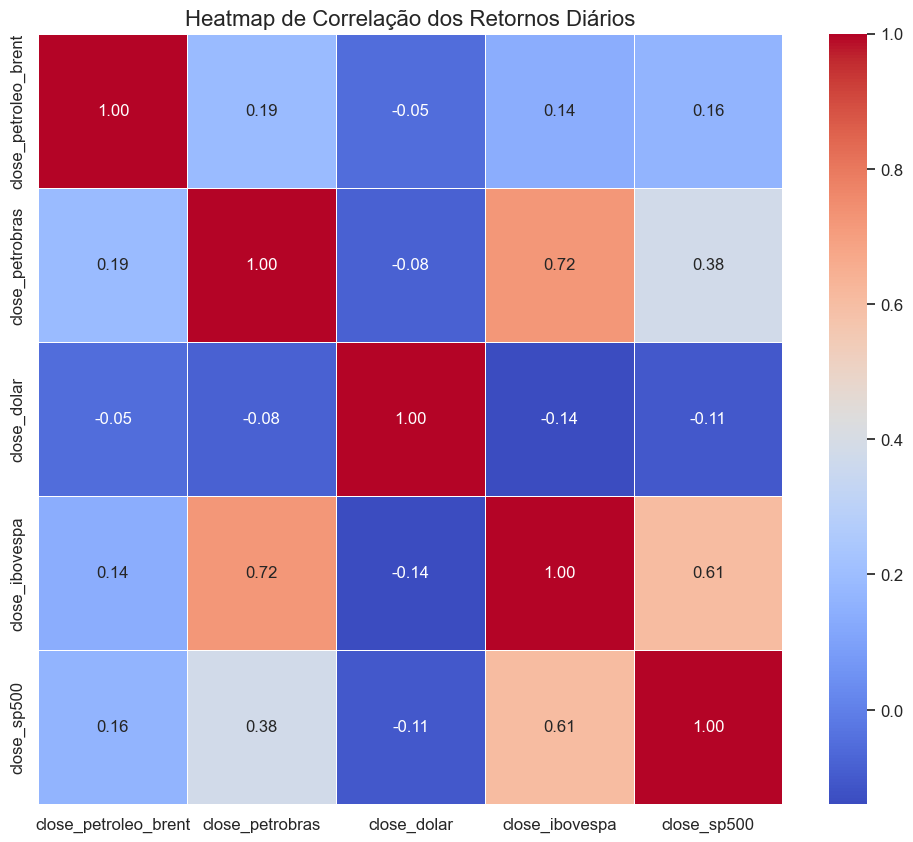


Matriz de Correlação:


close_petroleo_brent  close_petrobras  close_dolar  \
close_petroleo_brent                  1.00             0.19        -0.05   
close_petrobras                       0.19             1.00        -0.08   
close_dolar                          -0.05            -0.08         1.00   
close_ibovespa                        0.14             0.72        -0.14   
close_sp500                           0.16             0.38        -0.11   

                      close_ibovespa  close_sp500  
close_petroleo_brent            0.14         0.16  
close_petrobras                 0.72         0.38  
close_dolar                    -0.14        -0.11  
close_ibovespa                  1.00         0.61  
close_sp500                     0.61         1.00

In [9]:
# O DataFrame 'df_returns' foi calculado na célula anterior e já contém os retornos diários.

# 1. Calcular a matriz de correlação
correlation_matrix = df_returns.corr()

# 2. Criar o heatmap para visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True,          # Mostra os valores de correlação no mapa
    cmap='coolwarm',     # Escolhe um mapa de cores que distingue bem positivo/negativo
    fmt=".2f",           # Formata os números com duas casas decimais
    linewidths=.5
)

plt.title('Heatmap de Correlação dos Retornos Diários')
plt.show()

# Exibe a matriz de correlação como uma tabela para referência
print("\nMatriz de Correlação:")
display(correlation_matrix)

c:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov\.venv\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov\.venv\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


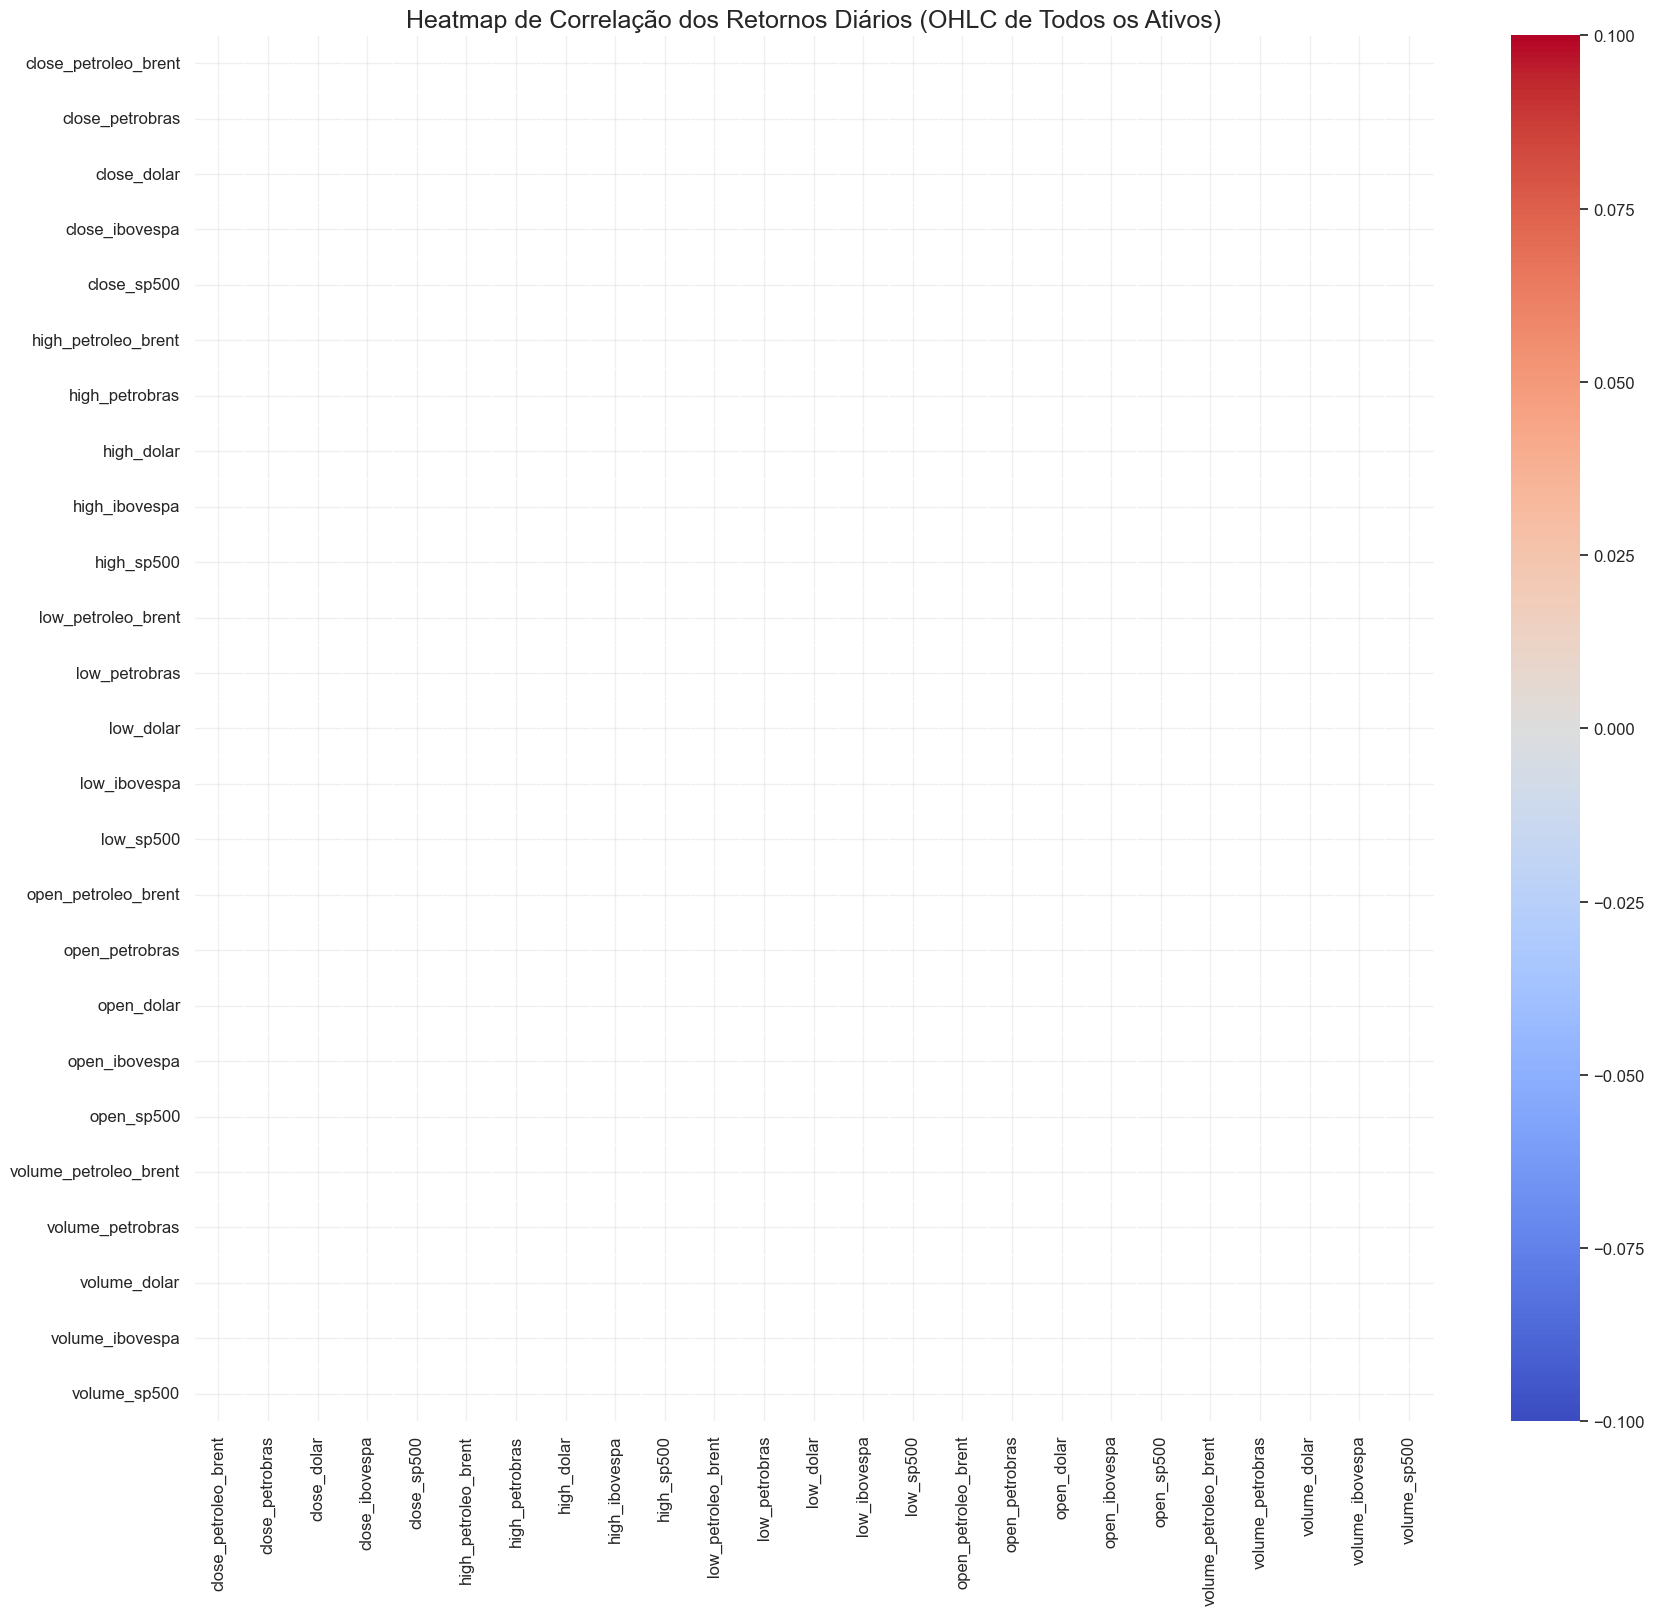

In [11]:
# O DataFrame 'df' já foi carregado e está com o índice de data.
# Ele contém todas as nossas colunas OHLC já renomeadas (ex: 'open_ibovespa').

# 1. Calcula os retornos diários para TODAS as colunas do DataFrame
# (exceto a 'semana_do_mes', que não é um preço)
df_returns_ohlc = df.drop(columns=['semana_do_mes']).pct_change()

# 2. Remove a primeira linha que será NaN
df_returns_ohlc = df_returns_ohlc.dropna()

# 3. Agora sim, calculamos a matriz de correlação sobre esses retornos
correlation_matrix_ohlc = df_returns_ohlc.corr()

# 4. Plotamos o heatmap
# Aumentamos o tamanho da figura para acomodar a matriz maior
plt.figure(figsize=(20, 18))
sns.heatmap(
    correlation_matrix_ohlc, 
    annot=True,          # Mostra os valores
    cmap='coolwarm',     # Mapa de cores
    fmt=".2f",           # Formato dos números
    linewidths=.5
)
plt.title('Heatmap de Correlação dos Retornos Diários (OHLC de Todos os Ativos)', fontsize=18)
plt.show()

## 🔥 Análise do Heatmap de Correlação (Retornos Diários OHLC)

O mapa de calor apresenta as correlações lineares entre os retornos diários dos ativos com base nas métricas OHLC (Open, High, Low, Close). A análise focada no comportamento do **Ibovespa** destaca relações relevantes com outros indicadores de mercado:

---

### 📌 **Principais Insights:**

#### 🇺🇸 Forte Influência do Mercado Americano (S&P 500)
- A correlação entre **`close_ibovespa`** e **`close_sp500`** é de **+0.50**.
- Esta relação positiva, presente de forma consistente nas métricas OHLC, reforça a ideia de que o humor do mercado norte-americano impacta diretamente o mercado brasileiro.

#### 🧭 Dinâmica Interna Surpreendente do IBOVESPA
- A correlação entre **`open_ibovespa`** e **`close_ibovespa`** é quase **nula (-0.05)**.
- Isso indica que o preço de abertura não antecipa o comportamento do fechamento no mesmo dia, sugerindo que o movimento intradiário define a direção do mercado.

#### 💵 Relação Inversa com o Dólar
- A correlação entre **`close_ibovespa`** e **`close_dolar`** é de **-0.10**.
- Apesar de fraca, essa relação negativa confirma a dinâmica clássica de aversão ao risco, onde a alta do dólar está associada à queda do mercado acionário.

#### 🛢️ Impacto de Ações-Chave (Petrobras)
- A correlação entre **`close_ibovespa`** e **`close_petrobras`** é de **+0.75**.
- Reforça o peso significativo de empresas como a Petrobras na formação do índice Ibovespa.

---

### 🤖 Conclusões para a Modelagem

Essa análise estatística auxilia na seleção de variáveis relevantes para modelos preditivos. Os retornos de:
- **S&P 500**
- **Petrobras**
- **Dólar**

surgem como os **candidatos mais promissores a features explicativas** do comportamento do Ibovespa, e podem ser integrados a modelos de regressão, classificação ou séries temporais em fases posteriores do projeto.

---

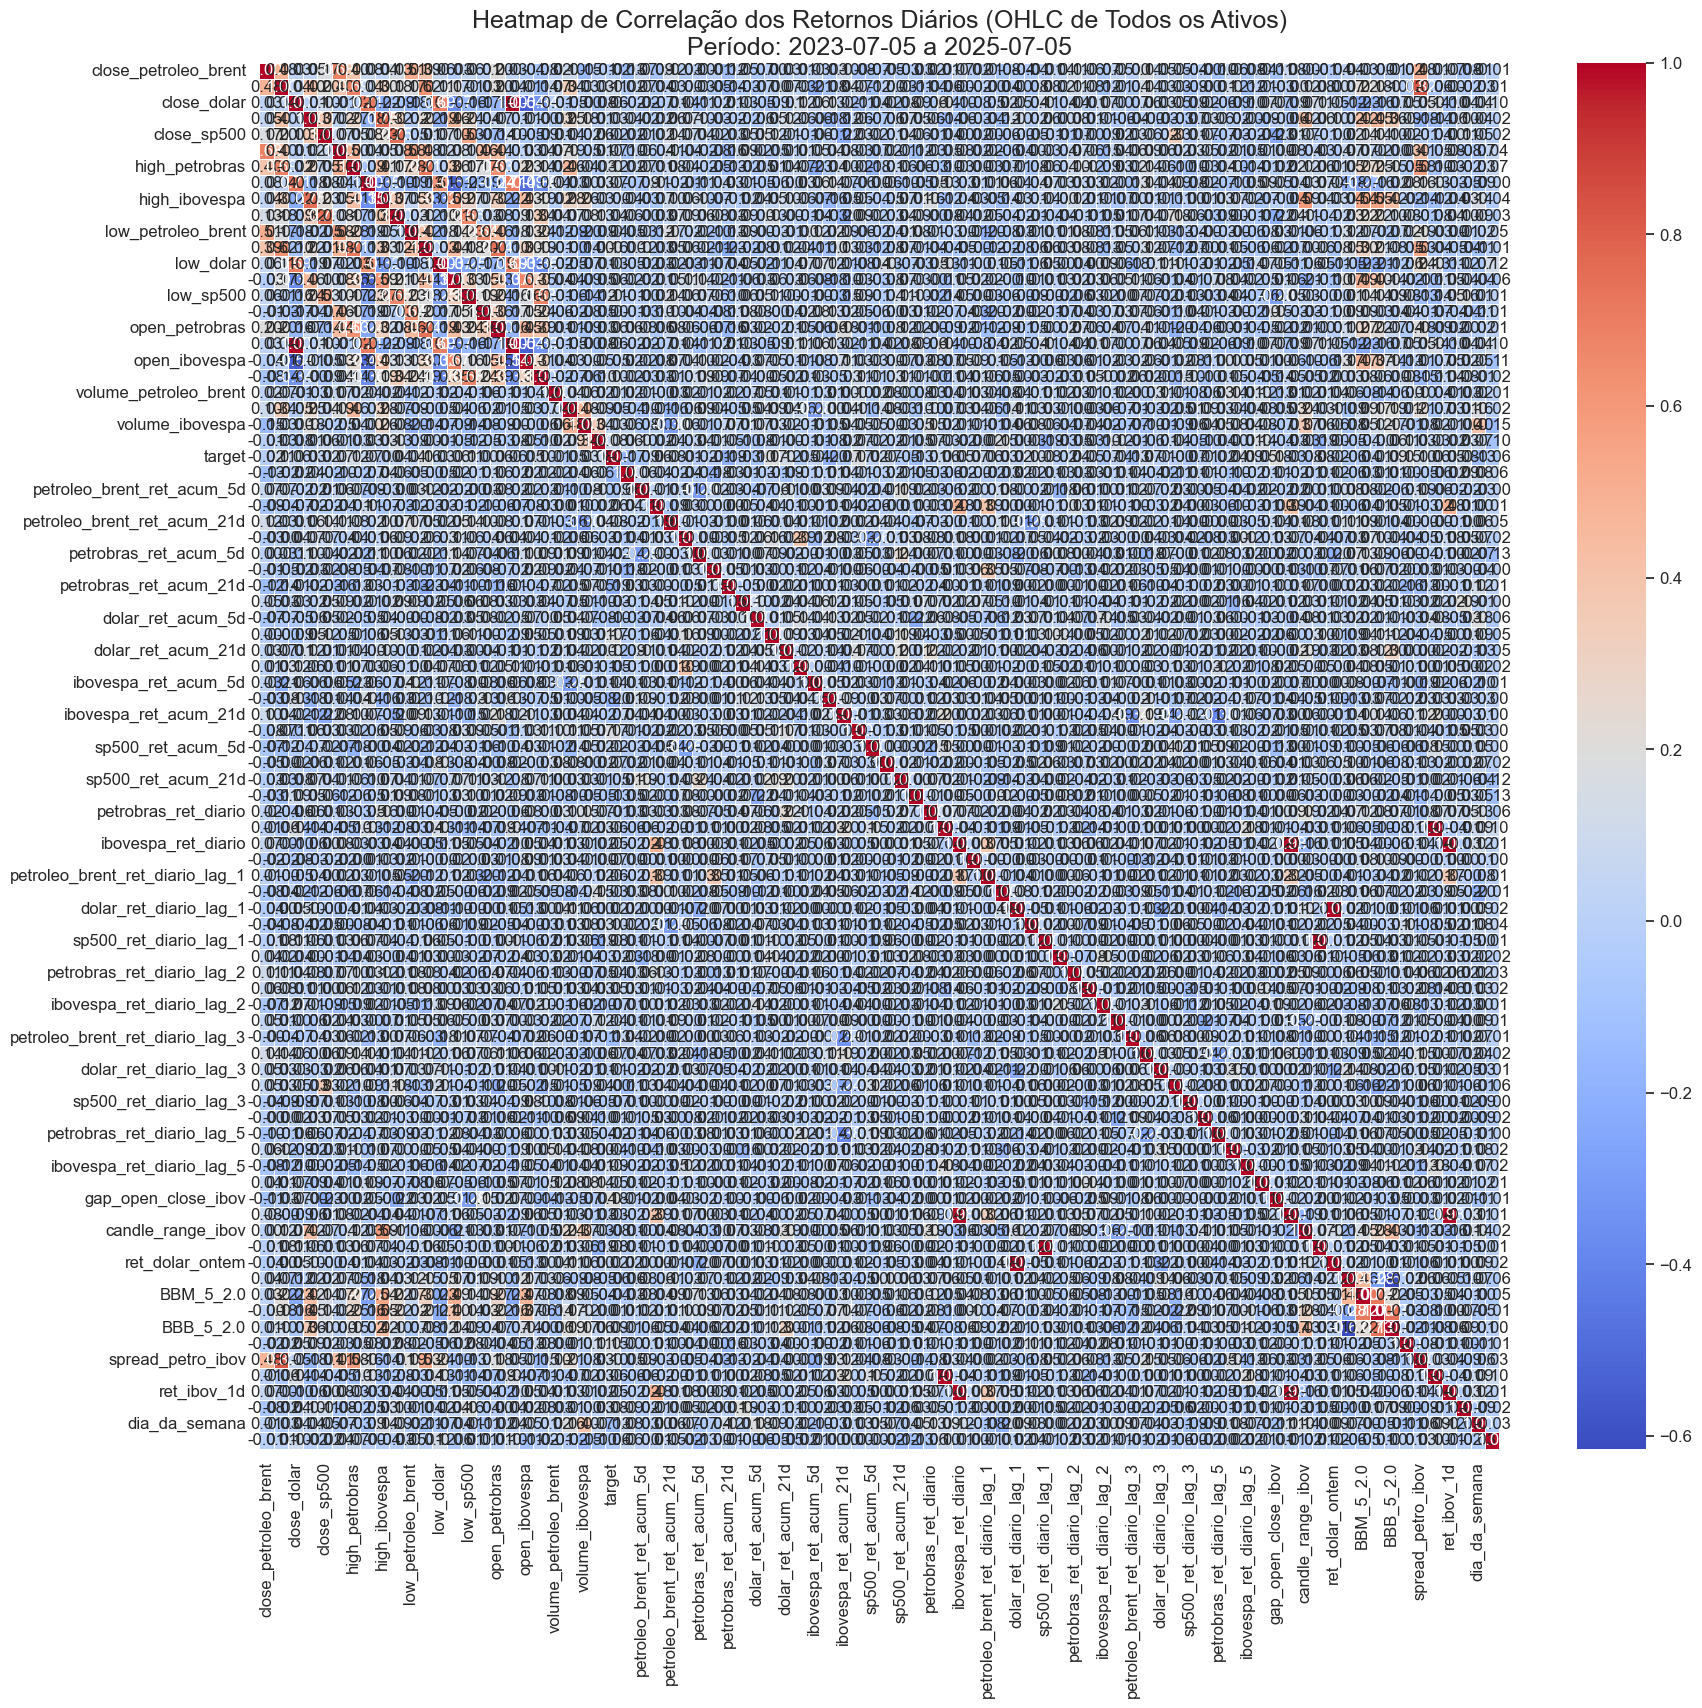

In [20]:
# Definindo o período dos últimos 2 anos
start_date_2y = '2023-07-05'
end_date_2y = '2025-07-05'

# Filtrando o DataFrame para o período de 2 anos
df_2y = df.loc[start_date_2y:end_date_2y]


# 1. Calcula os retornos diários para TODAS as colunas do DataFrame
# (exceto a 'semana_do_mes', que não é um preço)
df_returns_ohlc_2y = df_2y.drop(columns=['semana_do_mes']).pct_change()
df_returns_ohlc_2y = df_returns_ohlc_2y.dropna(axis=1, how='all')

# 2. Remove a primeira linha que será NaN
df_returns_ohlc_2y = df_returns_ohlc_2y.dropna()

# 3. Calcula a matriz de correlação sobre esses retornos
correlation_matrix_ohlc_2y = df_returns_ohlc_2y.corr()

# 4. Plotamos o heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(
    correlation_matrix_ohlc_2y, 
    annot=True,          # Mostra os valores
    cmap='coolwarm',     # Mapa de cores
    fmt=".2f",           # Formato dos números
    linewidths=.5
)
plt.title(f'Heatmap de Correlação dos Retornos Diários (OHLC de Todos os Ativos)\nPeríodo: {start_date_2y} a {end_date_2y}', fontsize=18)
plt.show()

## 🧊 Comparativo de Heatmaps: Período Completo vs. Últimos 2 Anos

Ao comparar os mapas de calor de correlação entre os retornos diários dos ativos para dois períodos — o **histórico completo** e os **últimos dois anos** —, é possível observar mudanças importantes nas relações entre os ativos. Abaixo, destacamos os principais insights extraídos dessa comparação:

---

### 1️⃣ Correlação com o S&P 500 Enfraqueceu
- **Histórico completo:** +0.50  
- **Últimos 2 anos:** +0.39  

🔍 **Insight:**  
Embora o mercado americano continue influenciando positivamente o Ibovespa, essa influência se tornou **menos direta** no período recente. Isso pode indicar maior impacto de **fatores internos** como política, juros ou desempenho setorial específico no Brasil.

---

### 2️⃣ Influência da Petrobras Diminuiu Drasticamente
- **Histórico completo:** +0.75  
- **Últimos 2 anos:** +0.44  

🔍 **Insight:**  
A **dependência do Ibovespa em relação à Petrobras** foi significativamente reduzida. Isso pode indicar a ascensão de outros setores (como financeiro, elétrico ou varejo) como principais vetores de movimento do índice no período recente.

---

### 3️⃣ Relação com o Dólar Permanece Estável (Fraca e Negativa)
- **Histórico completo:** -0.10  
- **Últimos 2 anos:** -0.08  

🔍 **Insight:**  
A dinâmica tradicional se mantém: quando o dólar sobe, a bolsa tende a cair — ainda que essa relação continue **estatisticamente fraca**.

---

### 4️⃣ Dinâmica Interna do Ibovespa se Confirma
- **Correlação open x close (Ibovespa):**
  - Histórico completo: -0.05  
  - Últimos 2 anos: -0.02  

🔍 **Insight:**  
A abertura do pregão segue sendo **pouco preditiva** do seu fechamento. A direção do mercado é, de fato, definida durante o dia de negociação. Trata-se de uma **característica estrutural estável** do índice.

---

## 🎯 Conclusão Estratégica para o Modelo

A análise revela que **as correlações entre os ativos não são estáticas** — elas variam com o tempo.

### 🧠 Implicações para a Modelagem:
- Dar **mais peso aos dados recentes** pode ser vantajoso, já que os drivers de mercado mudaram.
- **S&P 500 e Petrobras** continuam relevantes, mas com influência menor do que o histórico completo indicava.
- O **Dólar** se mantém como uma feature secundária, dada sua correlação fraca porém persistente.

Essa análise reforça a importância de aplicar **janelas móveis** ou **modelagem temporal adaptativa** para capturar mudanças de regime no comportamento do mercado.

---

## 🏗️ Engenharia de Atributos: Criação da Variável Alvo

---------------------- PRECISA SER ATUALIZADA CONFORME CÓDIGO ABAIXO




In [13]:
import numpy as np # Importar numpy é uma boa prática para operações numéricas

print("--- Iniciando Engenharia de Atributos com Threshold para Alta ---")

# --- PASSO 1: Definir o threshold de alta ---
# Apenas movimentos positivos ACIMA deste valor serão considerados 'alta' (1).
# Ex: 0.5% de ganho.
# melhores resultados 0.003
THRESHOLD_ALTA = 0.005

# --- PASSO 2: Calcular o retorno do dia seguinte ---
# Usamos .shift(-1) para trazer o valor de fechamento de amanhã para a linha de hoje.
retorno_seguinte = (df['close_ibovespa'].shift(-1) / df['close_ibovespa']) - 1

# --- PASSO 3: Criar o alvo com a lógica do threshold ---
# A condição (retorno_seguinte > THRESHOLD_ALTA) retornará:
# - True (que vira 1) se o retorno for maior que o threshold.
# - False (que vira 0) se o retorno for menor ou igual ao threshold (incluindo perdas).
df['target'] = (retorno_seguinte > THRESHOLD_ALTA).astype(int)

# --- PASSO 4: Lidando com o último valor (que será NaN) ---
# A última linha do DataFrame terá um 'alvo' que não pode ser calculado.
# A conversão .astype(int) pode gerar um erro ou um valor inesperado dependendo da versão do pandas.
# É mais seguro remover a linha onde o alvo não pôde ser calculado.
df.dropna(subset=['target'], inplace=True)
# Se preferir, pode converter para um tipo inteiro que aceita nulos:
# df['alvo'] = df['alvo'].astype('Int64') 


# --- Verificação do resultado ---
print(f"\nThreshold para considerar alta: {THRESHOLD_ALTA*100}%")
print("Alvo será 1 apenas se o ganho do dia seguinte for superior a este valor.")

# Para uma boa verificação, vamos criar colunas temporárias para exibir a lógica
df_display = df.copy()
df_display['retorno_seguinte_%'] = ((df['close_ibovespa'].shift(-1) / df['close_ibovespa']) - 1) * 100
print("\nExibindo as últimas 10 linhas para verificação da lógica do alvo:")
display(df_display[['close_ibovespa', 'retorno_seguinte_%', 'target']].tail(10))

--- Iniciando Engenharia de Atributos com Threshold para Alta ---

Threshold para considerar alta: 0.5%
Alvo será 1 apenas se o ganho do dia seguinte for superior a este valor.

Exibindo as últimas 10 linhas para verificação da lógica do alvo:


close_ibovespa  retorno_seguinte_%  target
data                                                  
2025-07-11       136187.00               -0.65       0
2025-07-14       135299.00               -0.04       0
2025-07-15       135250.00                0.19       0
2025-07-16       135511.00                0.04       0
2025-07-17       135565.00               -1.61       0
2025-07-18       133382.00                0.59       1
2025-07-21       134167.00               -0.10       0
2025-07-22       134036.00                0.99       1
2025-07-23       135368.00               -1.15       0
2025-07-24       133808.00                 NaN       0

## ⚙️ Engenharia de Atributos: Retornos Acumulados (Momentum) e Lags

Nesta etapa, expandimos a base de dados com **novas variáveis explicativas** construídas a partir dos preços de fechamento (`close_`). O objetivo é capturar comportamentos históricos relevantes que possam ajudar na previsão da direção do Ibovespa.

---

### 📌 Etapas realizadas:

#### 1️⃣ Identificação das Colunas de Fechamento
Selecionamos todas as colunas que representam preços de fechamento dos ativos por meio do prefixo `close_`.

#### 2️⃣ Criação de Features de Momentum (Retorno Acumulado)
- Utilizamos `.pct_change(periods=N)` para calcular o **retorno acumulado** nos últimos N dias úteis.
- Períodos utilizados: **2, 5, 10 e 21 dias** (este último representa aproximadamente 1 mês).
- Exemplo de feature criada: `ibovespa_ret_acum_5d`.

#### 3️⃣ Criação de Features de Lag (Retorno Diário Defasado)
- Primeiro, calculamos o **retorno diário** dos ativos (`ret_diario`) com `pct_change(1)`.
- Depois, aplicamos `.shift(N)` para obter o valor desses retornos em dias anteriores (lags).
- Lags utilizados: **1, 2, 3 e 5 dias**.
- Exemplo de feature criada: `ibovespa_ret_diario_lag_3`.

#### 4️⃣ Consolidação das Features
As novas colunas (`momentum`, `retornos_diários` e `lags`) são concatenadas ao DataFrame original.

#### 5️⃣ Limpeza Final
Removemos as linhas com valores nulos gerados pelas operações de `shift()` e `pct_change()` com `df.dropna(inplace=True)`.

---

✅ Ao final dessa etapa, o DataFrame está enriquecido com diversas **features temporais derivadas dos preços**, prontas para análise exploratória ou modelagem preditiva.


In [14]:
# O DataFrame 'df' já foi carregado e está com o índice de data.

print("--- Iniciando Engenharia de Atributos: Features de Retorno e Lag ---")

# 1. Identificar todas as colunas de fechamento que já foram renomeadas
colunas_close = [col for col in df.columns if col.startswith('close_')]

# 2. Criar features de "Momentum" (retorno acumulado de N dias)
periodos_momentum = [2, 5, 10, 21] # Retorno dos últimos 2, 5, 10 e 21 dias úteis (aprox. 1 mês)
for col in colunas_close:
    nome_base = col.replace('close_', '')
    for p in periodos_momentum:
        df[f'{nome_base}_ret_acum_{p}d'] = df[col].pct_change(periods=p)

# 3. Criar features de "Lag" (retorno exato de N dias atrás)
# Primeiro, calculamos o retorno diário para todas as colunas de fechamento
df_retornos_diarios = df[colunas_close].pct_change(periods=1)

# Renomeamos as colunas para um formato limpo, ex: 'ibovespa_ret_diario'
df_retornos_diarios.columns = [f'{col.replace("close_", "")}_ret_diario' for col in colunas_close]

# Agora, criamos os lags sobre esses retornos diários
periodos_de_lag = [1, 2, 3, 5] # Retorno de 1, 2, 3 e 5 dias atrás
colunas_para_lag = df_retornos_diarios.columns.tolist()

df_lagged = pd.DataFrame(index=df.index)
for lag in periodos_de_lag:
    for col in colunas_para_lag:
        # O nome da nova coluna será ex: 'ibovespa_ret_diario_lag_1'
        df_lagged[f'{col}_lag_{lag}'] = df_retornos_diarios[col].shift(lag)

# 4. Juntar todas as novas features ao DataFrame principal
df = pd.concat([df, df_retornos_diarios, df_lagged], axis=1)

# 5. Limpeza final dos NaNs gerados por todos os cálculos
print(f"Número de linhas antes de remover NaNs: {len(df)}")
df.dropna(inplace=True)
print(f"Número de linhas após remover NaNs: {len(df)}")

print("\n✅ Features de Momentum e Lag criadas com sucesso.")
display(df.filter(like='ibovespa').tail())

--- Iniciando Engenharia de Atributos: Features de Retorno e Lag ---
Número de linhas antes de remover NaNs: 5359
Número de linhas após remover NaNs: 5338

✅ Features de Momentum e Lag criadas com sucesso.


close_ibovespa  high_ibovespa  low_ibovespa  open_ibovespa  \
data                                                                     
2025-07-18       133382.00      135563.00     133296.00      135563.00   
2025-07-21       134167.00      134865.00     133367.00      133382.00   
2025-07-22       134036.00      135300.00     133986.00      134180.00   
2025-07-23       135368.00      135782.00     133676.00      134036.00   
2025-07-24       133808.00      135363.00     133648.00      135357.00   

            volume_ibovespa  ibovespa_ret_acum_2d  ibovespa_ret_acum_5d  \
data                                                                      
2025-07-18      10071800.00                 -0.02                 -0.02   
2025-07-21       6726700.00                 -0.01                 -0.01   
2025-07-22       7052100.00                  0.00                 -0.01   
2025-07-23       6527600.00                  0.01                 -0.00   
2025-07-24       5976800.00                 -0.00                 -0.01   

            ibovespa_ret_acum_10d  ibovespa_ret_acum_21d  ibovespa_ret_diario  \
data                                                                            
2025-07-18                  -0.06                  -0.04                -0.02   
2025-07-21                  -0.04                  -0.02                 0.01   
2025-07-22                  -0.04                  -0.02                -0.00   
2025-07-23                  -0.02                  -0.01                 0.01   
2025-07-24                  -0.02                  -0.01                -0.01   

            ibovespa_ret_diario_lag_1  ibovespa_ret_diario_lag_2  \
data                                                               
2025-07-18                       0.00                       0.00   
2025-07-21                      -0.02                       0.00   
2025-07-22                       0.01                      -0.02   
2025-07-23                      -0.00                       0.01   
2025-07-24                       0.01                      -0.00   

            ibovespa_ret_diario_lag_3  ibovespa_ret_diario_lag_5  
data                                                              
2025-07-18                      -0.00                      -0.00  
2025-07-21                       0.00                      -0.01  
2025-07-22                       0.00                      -0.00  
2025-07-23                      -0.02                       0.00  
2025-07-24                       0.01                       0.00

## 🧠 Engenharia de Atributos Avançada: Sinais de Mercado Além dos Preços

O objetivo desta etapa é **ir além dos dados brutos de preços** e fornecer ao nosso modelo de Machine Learning um conjunto de **sinais mais ricos, informativos e interpretáveis**. Cada grupo de features foi projetado para capturar uma dinâmica específica do mercado, traduzindo movimentos e padrões em variáveis numéricas úteis para a modelagem.

---

### 1️⃣ Indicadores Intradiários (Candle Features)

📌 **Poder e Implicação:**  
As colunas OHLC (Open, High, Low, Close) descrevem a história completa de um dia de negociação. A partir delas, extraímos:

- **`gap_open_close`**: mede o "salto" de preço entre o fechamento anterior e a abertura atual, capturando o **sentimento overnight**.
- **`candle_body_ibov`**: quantifica a força e a direção do movimento intradiário.
- **`candle_range_ibov`**: representa a **volatilidade do dia**, medindo a diferença entre máxima e mínima.

---

### 2️⃣ Indicadores Globais Defasados (Efeito Overnight)

📌 **Poder e Implicação:**  
O Ibovespa não opera isoladamente. Fatores globais do dia anterior podem afetar diretamente o sentimento de abertura e a direção do pregão atual.

- **`ret_sp500_ontem`**: retorno do S&P 500 no dia anterior.
- **`ret_dolar_ontem`**: variação do dólar na véspera.

Essas features fornecem **contexto internacional** e ajudam a modelar efeitos de contágio e correlação entre mercados.

---

### 3️⃣ Indicadores Técnicos (RSI, MACD, Bandas de Bollinger)

📌 **Poder e Implicação:**  
Estamos incluindo sinais que refletem a **lógica de decisão de traders reais**, como:

- **RSI (Índice de Força Relativa)**: mede o momentum, identificando condições de sobrecompra/sobrevenda.
- **MACD (Moving Average Convergence Divergence)**: capta o início e o fim de tendências.
- **Bandas de Bollinger**: oferecem uma medida dinâmica de **volatilidade** e **extremos de preço** em relação à média.

Esses indicadores ajudam o modelo a aprender **padrões táticos** comuns do mercado.

---

### 4️⃣ Relações e Spreads entre Ativos

📌 **Poder e Implicação:**  
O mercado funciona por **comparação** e **valor relativo**.

- **`spread_petro_ibov`**: performance relativa da Petrobras vs. Ibovespa.
- **`ret_diff_dolar_ibov`**: diferença entre os retornos do dólar e do Ibovespa, indicando movimentos de **risk-on / risk-off**.

Essas variáveis revelam **distorções e divergências** que costumam se corrigir com o tempo.

---

### 5️⃣ Variáveis Temporais Categóricas

📌 **Poder e Implicação:**  
O comportamento do mercado pode seguir **padrões sazonais** e **efeitos comportamentais** recorrentes:

- **`dia_da_semana`**: permite capturar efeitos como o "Monday Effect".
- **`mes`**: permite capturar tendências específicas de certos períodos do ano (ex: janeiro, dezembro).

---

### ✅ Conclusão

Com esse conjunto de variáveis, **transformamos o DataFrame** de uma simples tabela de preços para uma **representação rica da dinâmica do mercado financeiro**.

Isso fornece ao modelo uma base muito mais sólida para **aprender padrões relevantes** e realizar **previsões acuradas**, elevando significativamente o potencial preditivo da solução.


In [15]:
# O DataFrame 'df' já contém o alvo e as features de lag anteriores.

print("--- Iniciando Engenharia de Atributos Avançada ---")

# Garante que a data esteja no formato datetime para os cálculos
df.index = pd.to_datetime(df.index)

# 1. Indicadores Intradiários (Candle Features)
df['gap_open_close_ibov'] = df['open_ibovespa'] - df['close_ibovespa'].shift(1)
df['candle_body_ibov'] = df['close_ibovespa'] - df['open_ibovespa']
df['candle_range_ibov'] = df['high_ibovespa'] - df['low_ibovespa']

# 2. Indicadores Globais Defasados (efeito overnight)
# (Já criamos os retornos em uma célula anterior, vamos reutilizá-los e criar o lag)
df['ret_sp500_ontem'] = df['close_sp500'].pct_change().shift(1)
df['ret_dolar_ontem'] = df['close_dolar'].pct_change().shift(1)

# 3. Indicadores Técnicos (usando pandas-ta para consistência)
df.ta.bbands(close=df['close_ibovespa'], append=True) # Cria 3 colunas para as Bandas de Bollinger

# Renomeia as colunas do pandas-ta para nosso padrão
df.rename(columns={
    'BBL_20_2.0': 'bb_lower_ibov',
    'BBM_20_2.0': 'bb_middle_ibov',
    'BBU_20_2.0': 'bb_upper_ibov',
    'BBP_20_2.0': 'bb_percent_ibov',
    'BBB_20_2.0': 'bb_width_ibov',
    'RSI_14': 'rsi_ibov', # Já tínhamos o RSI da célula anterior
    'MACD_12_26_9': 'macd_ibov',
    'MACDh_12_26_9': 'macd_hist_ibov',
    'MACDs_12_26_9': 'macd_signal_ibov'
}, inplace=True)


# 4. Relações e Spreads entre Ativos
df['spread_petro_ibov'] = df['close_petrobras'] / df['close_ibovespa']

# Precisamos dos retornos diários que já calculamos
df['ret_dolar_1d'] = df['close_dolar'].pct_change(1)
df['ret_ibov_1d'] = df['close_ibovespa'].pct_change(1)
df['ret_diff_dolar_ibov'] = df['ret_dolar_1d'] - df['ret_ibov_1d']

# 5. Variáveis Temporais Categóricas
df['dia_da_semana'] = df.index.dayofweek  # 0 = Segunda, 6 = Domingo
df['mes'] = df.index.month

# 6. Limpeza final dos NaNs gerados
print(f"\nNúmero de linhas antes de remover NaNs: {len(df)}")
df.dropna(inplace=True)
print(f"Número de linhas após remover NaNs: {len(df)}")

print("\n✅ Novas features avançadas criadas com sucesso.")
display(df.tail())

--- Iniciando Engenharia de Atributos Avançada ---

Número de linhas antes de remover NaNs: 5338
Número de linhas após remover NaNs: 5334

✅ Novas features avançadas criadas com sucesso.


close_petroleo_brent  close_petrobras  close_dolar  \
data                                                             
2025-07-18                 67.34            30.99         5.55   
2025-07-21                 67.20            31.05         5.58   
2025-07-22                 66.21            31.35         5.57   
2025-07-23                 65.25            31.99         5.56   
2025-07-24                 66.03            31.94         5.52   

            close_ibovespa  close_sp500  high_petroleo_brent  high_petrobras  \
data                                                                           
2025-07-18       133382.00      6296.79                68.96           31.60   
2025-07-21       134167.00      6305.60                67.76           31.28   
2025-07-22       134036.00      6309.62                67.13           31.58   
2025-07-23       135368.00      6358.91                65.78           32.03   
2025-07-24       133808.00      6363.35                66.39           32.02   

            high_dolar  high_ibovespa  high_sp500  low_petroleo_brent  \
data                                                                    
2025-07-18        5.56      135563.00     6315.61               67.20   
2025-07-21        5.60      134865.00     6336.08               66.46   
2025-07-22        5.59      135300.00     6316.12               65.99   
2025-07-23        5.58      135782.00     6360.64               64.71   
2025-07-24        5.54      135363.00     6381.31               65.33   

            low_petrobras  low_dolar  low_ibovespa  low_sp500  \
data                                                            
2025-07-18          30.60       5.52     133296.00    6285.27   
2025-07-21          30.77       5.54     133367.00    6303.79   
2025-07-22          30.99       5.55     133986.00    6281.71   
2025-07-23          31.30       5.54     133676.00    6317.49   
2025-07-24          31.65       5.51     133648.00    6360.57   

            open_petroleo_brent  open_petrobras  open_dolar  open_ibovespa  \
data                                                                         
2025-07-18                67.60           31.40        5.55      135563.00   
2025-07-21                67.32           30.89        5.58      133382.00   
2025-07-22                67.12           31.05        5.57      134180.00   
2025-07-23                65.49           31.35        5.56      134036.00   
2025-07-24                65.42           31.93        5.52      135357.00   

            open_sp500  volume_petroleo_brent  volume_petrobras  volume_dolar  \
data                                                                            
2025-07-18     6312.95              107628.00       57635000.00          0.00   
2025-07-21     6304.74               81194.00       16412000.00          0.00   
2025-07-22     6306.60              269991.00       24557100.00          0.00   
2025-07-23     6326.90              251825.00       27418600.00          0.00   
2025-07-24     6368.60              251825.00       17856300.00          0.00   

            volume_ibovespa  volume_sp500  semana_do_mes  target  \
data                                                               
2025-07-18      10071800.00 5184700000.00              3       1   
2025-07-21       6726700.00 5010840000.00              3       0   
2025-07-22       7052100.00 5662040000.00              4       1   
2025-07-23       6527600.00 5642510000.00              4       0   
2025-07-24       5976800.00 5282720000.00              4       0   

            petroleo_brent_ret_acum_2d  petroleo_brent_ret_acum_5d  \
data                                                                 
2025-07-18                        0.01                       -0.02   
2025-07-21                       -0.01                        0.00   
2025-07-22                       -0.02                       -0.00   
2025-07-23                       -0.03                       -0.02   
2025-07-

## 💾 Salvando o DataFrame Final com Features no Banco de Dados (DuckDB)

Após todas as etapas de engenharia de atributos, é essencial **persistir os dados enriquecidos** em uma tabela para garantir reprodutibilidade e facilitar futuras análises ou uso em pipelines de modelagem.

---

### 🗃️ Etapas Realizadas:

1. **Nomeação da Tabela**
   - Definimos o nome da nova tabela no banco como: `features_baseline`.

2. **Conexão ao Banco DuckDB**
   - Utilizamos o caminho previamente configurado no módulo `config`.
   - A conexão é feita em modo de escrita (`read_only=False`).

3. **Criação ou Substituição da Tabela**
   - A tabela é criada (ou substituída, caso já exista) com os dados do DataFrame `df` usando o comando:
     ```sql
     CREATE OR REPLACE TABLE features_baseline AS SELECT * FROM df
     ```

4. **Verificação**
   - Após salvar, listamos as tabelas existentes no banco para confirmar que `features_baseline` foi criada com sucesso.

---

✅ Ao final dessa etapa, todos os dados transformados e prontos para modelagem estão **armazenados de forma segura** em um banco de dados local, promovendo organização, rastreabilidade e facilidade de acesso para as próximas fases do projeto.


In [17]:
df_para_salvar = df.reset_index()

# Define o nome para nossa nova tabela de features
nome_tabela_features = "features_baseline"

# O caminho do DB já está no nosso módulo 'config'
db_path = str(config.DB_PATH)

print(f"Salvando o DataFrame final com features na tabela '{nome_tabela_features}' em: {db_path}")

try:
    # Conecta ao nosso banco de dados já existente em modo de escrita
    con = duckdb.connect(database=db_path, read_only=False)

    # Salva o DataFrame na nova tabela, substituindo-a se já existir
    con.execute(f"CREATE OR REPLACE TABLE {nome_tabela_features} AS SELECT * FROM df_para_salvar")

    # Verifica as tabelas no banco de dados para confirmar a criação
    print("\nTabelas existentes no banco de dados:")
    display(con.execute("SHOW TABLES").fetchdf())

    con.close()
    
    print(f"\n✅ DataFrame de features salvo com sucesso na tabela '{nome_tabela_features}'!")

except Exception as e:
    print(f"❌ Ocorreu um erro ao salvar no banco de dados: {e}")

Salvando o DataFrame final com features na tabela 'features_baseline' em: C:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov\data\mercados.duckdb

Tabelas existentes no banco de dados:


name
0  features_baseline
1     precos_diarios


✅ DataFrame de features salvo com sucesso na tabela 'features_baseline'!


## ✅ Conclusão da Fase 2: Análise e Engenharia de Atributos

Esta fase teve como objetivo transformar os dados brutos e limpos obtidos na Fase 1 em um conjunto estruturado, informativo e pronto para ser usado em algoritmos de **Machine Learning**. O processo foi dividido em duas frentes principais: **Análise Exploratória de Dados (EDA)** e **Engenharia de Atributos**.

---

### 🔍 Principais Insights da Análise Exploratória (EDA)

Através de análises estatísticas e visualizações, extraímos conclusões relevantes sobre o comportamento do mercado e suas relações:

- **📉 Mudança de Regime**  
  A comparação entre o período histórico completo e os últimos 2 anos revelou que as **correlações entre ativos não são estáticas**. A influência do **S&P 500** e da **Petrobras** sobre o IBOVESPA diminuiu, indicando uma possível **mudança estrutural** no comportamento do índice.

- **⚠️ Comportamento de Risco**  
  A distribuição dos retornos do Ibovespa mostrou **leptocurtose**, ou seja, **eventos extremos ocorrem com maior frequência** do que o esperado sob uma distribuição normal.

- **💵 Relações Clássicas Confirmadas**  
  A fraca correlação negativa entre o **Dólar** e o **Ibovespa** confirma um comportamento típico de **"risk-off"** no mercado brasileiro.

---

### 🏗️ Resultado da Engenharia de Atributos

Com base nos insights extraídos na EDA, construímos um conjunto robusto e diversificado de **variáveis preditoras**, transformando o DataFrame original em uma base muito mais informativa.

#### 📊 Grupos de Features Criadas:
- **Tendência e Momentum**: RSI, MACD, médias móveis, retornos acumulados (2, 5, 10, 21 dias).
- **Memória de Curto Prazo**: Lags dos retornos diários (1 a 5 dias).
- **Dinâmica Intraday**: Gap, corpo e range dos candles.
- **Relações Relativas**: Spreads e diferenças de retorno entre ativos (ex: Petrobras vs. Ibovespa).
- **Sazonalidade**: Variáveis de calendário como `dia_da_semana` e `mês`.

---

### 💾 Resultado Final

Todos os dados enriquecidos foram salvos na tabela `**features_baseline**`, dentro do banco de dados DuckDB, servindo como **matéria-prima para a modelagem preditiva**.

---

### 🚀 Próximo Passo: Fase 3 - Modelagem

Com a base estruturada e persistida, avançamos para a **Fase 3**, onde treinaremos e avaliaremos diferentes modelos de **Machine Learning** com o objetivo de prever a **tendência do IBOVESPA**.

Nesta próxima etapa, trabalharemos com:
- Preparação do dataset para modelagem.
- Treinamento e validação de modelos supervisionados.
- Seleção de métricas e tuning de hiperparâmetros.

O objetivo final é selecionar o **melhor modelo preditivo** possível com base na performance e capacidade de generalização.
